In [0]:
!apt-get install openslide-tools
!pip install openslide-python
!pip install tensorflow==2.0.0-alpha0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import pickle
import tensorflow as tf

In [0]:
#mount gdrive
from google.colab import drive

#check path to file
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Params to be changed**

In [0]:
root = 'gdrive/My Drive/adl_pro/'
slide_number = '110'
level = 3
dim = 299
stride = 20
tissue_percentage = 30
model = tf.keras.models.load_model(root + 'models/level3.h5')
prediction_name = 'tumor_110_predicted_mask_level3'

**No need to change anything below this.**

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
slide = open_slide(root + 'data/test/tumor_' + slide_number + '.tif')

x = 0
y = 0
width=slide.level_dimensions[level][0]
height=slide.level_dimensions[level][1]

image = read_slide(slide, x, y, level, width, height)

In [0]:
print(image.shape)

(8960, 11776, 3)


In [0]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [0]:
import gc
gc.collect()

4

In [0]:
result = np.zeros((image.shape[0],image.shape[1]))
for x in range(0,height-dim,stride):
  for y in range(0,width-dim,stride):
    slice = image[x:x+dim,y:y+dim,:]
    tissue = len(list(find_tissue_pixels(slice))) / float(slice.shape[0]**2) * 100
    if tissue > tissue_percentage:
      prediction = model.predict(np.expand_dims(slice, axis=0)).reshape(-1,2)
      lol = np.argmax(prediction,axis = 1)
      result[x:x+dim, y:y+dim] += lol
    if x % 200 == 0 and y % 500 == 0:
      print('Pointer at ',(x,y))

Pointer at  (0, 0)
Pointer at  (0, 500)
Pointer at  (0, 1000)
Pointer at  (0, 1500)
Pointer at  (0, 2000)
Pointer at  (0, 2500)
Pointer at  (0, 3000)
Pointer at  (0, 3500)
Pointer at  (0, 4000)
Pointer at  (0, 4500)
Pointer at  (0, 5000)
Pointer at  (0, 5500)
Pointer at  (0, 6000)
Pointer at  (0, 6500)
Pointer at  (0, 7000)
Pointer at  (0, 7500)
Pointer at  (0, 8000)
Pointer at  (0, 8500)
Pointer at  (0, 9000)
Pointer at  (0, 9500)
Pointer at  (0, 10000)
Pointer at  (0, 10500)
Pointer at  (0, 11000)
Pointer at  (200, 0)
Pointer at  (200, 500)
Pointer at  (200, 1000)
Pointer at  (200, 1500)
Pointer at  (200, 2000)
Pointer at  (200, 2500)
Pointer at  (200, 3000)
Pointer at  (200, 3500)
Pointer at  (200, 4000)
Pointer at  (200, 4500)
Pointer at  (200, 5000)
Pointer at  (200, 5500)
Pointer at  (200, 6000)
Pointer at  (200, 6500)
Pointer at  (200, 7000)
Pointer at  (200, 7500)
Pointer at  (200, 8000)
Pointer at  (200, 8500)
Pointer at  (200, 9000)
Pointer at  (200, 9500)
Pointer at  (200, 1

In [0]:
import gc
gc.collect()

0

In [0]:
with open(root + 'data/test/' + prediction_name + '.pkl','wb') as f:
  pickle.dump(result,f)

In [0]:
print(np.sum(result))

148584462.0


In [0]:
result.shape

(8960, 11776)

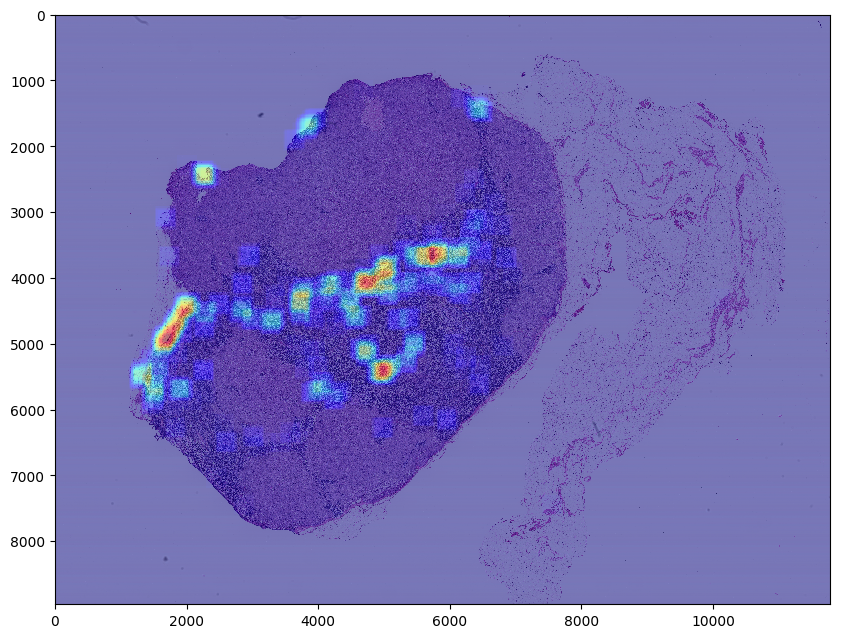

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(image)
plt.imshow(result, cmap='jet', alpha=0.5)

In [0]:
mask = open_slide(root + 'data/test/tumor_' + slide_number + '_mask.tif')

x = 0
y = 0
width=mask.level_dimensions[level][0]
height=mask.level_dimensions[level][1]

mask_image = read_slide(mask, x, y, level, width, height)
mask_image = mask_image[:,:,0]

In [0]:
mask_image.shape

(8960, 11776)

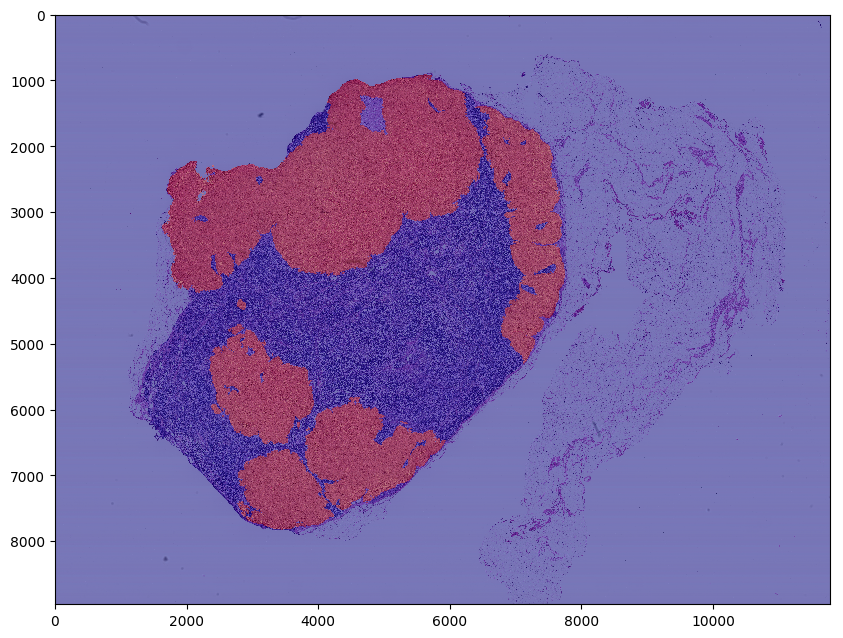

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [0]:
print(np.sum(mask_image))